# 2009年上海居民出行调查数据
* (1)family.csv
* (2)person.csv
* (3)trip.csv

# 2015年南京居民出行调查数据
* (1)家庭.sheet
* (2)成员.sheet
* (3)出行.sheet

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import shapely
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

pd.set_option('max_rows',1000)
pd.set_option('max_columns',50)

os.chdir('E:\\zhpy\\2travel_survey_2009SH')

### (1) 上海

In [2]:
# 上海-----------------------------------------------------------------
# W_XZ：单位行政区
# STREET：单位街道
# gender: （1.男 2.女）
# edu: (1.小学以下2.小学 3.初中 4.高中 5.大专6.本科 7.研究生及以上)
# job: （1.单位负责人2.专业技术人员3.办事人员及有关人员4.私营业主及个体经营者|5.农林牧渔水利生产人员6.生产运输设备操作人员
#        7.商业及服务人员8.离退休人员9.离退休再就业人员10.学生11.其它）
# income: (1.无 2.<1000   3.1001-2000 4.2001-3000   5.3001-5000 6.5001-10000  7.>10000)
# Pcharacter: (1.户籍人口  2.非户籍常住3.非户籍流动)
# iftrip: （1.出行  2.不出行）
# ifworkday: （1.工作日2.双休日）
personSH_cols = ['HomeID','PersonID','W_XZ','STREET','age','gender','edu','job','income','Pcharacter',\
               'iftrip','ifworkday','Pweight','UNIT_X','UNIT_Y']
personSH = pd.read_csv('./person.csv',usecols=personSH_cols)
personSH.iftrip = personSH.iftrip.apply(lambda x: x[2:])
personSH.ifworkday = personSH.ifworkday.apply(lambda x: x[2:])
personSH.sort_values(['HomeID','PersonID'],inplace=True)

In [3]:
personSH.head()

,PersonID,HomeID,W_XZ,STREET,age,gender,edu,job,income,Pcharacter,iftrip,ifworkday,Pweight,UNIT_X,UNIT_Y
0,1,1,青浦区,NaN,46,1,3,5,3,1.户籍人口,出行,工作日,89.22,121.020038,30.976588
1,2,1,青浦区,NaN,43,2,3,4,3,1.户籍人口,出行,工作日,72.74,121.020038,30.976588
2,3,2,青浦区,1盈浦,46,1,3,11,2,1.户籍人口,出行,工作日,235.11,121.467201,31.235452
3,4,2,青浦区,漕盈路,46,2,3,11,2,1.户籍人口,出行,工作日,179.28,121.467201,31.235452
4,5,2,青浦区,漕盈,23,2,5,2,2,1.户籍人口,出行,工作日,99.43,121.467201,31.235452


In [4]:
def time_string_format(t):
    # 将travel中time转换为时间格式
    hm = t.zfill(4)
    hms = hm[:2] + ':' + hm[2:] + ':00'
    return hms

In [5]:
# trip purpose: 1.上班 2.上学 3.购物 4.文化娱乐 5.业务 6.接送人 7.回家8.其它生活
tripSH_cols = ['HomeID','PersonID','Stime','Etime','Tpurpose','Tduration','Tmode','Tweight','FROM_X','FROM_Y','TO_X','TO_Y']
tripSH = pd.read_csv('./trip.csv',usecols=tripSH_cols,dtype={'Stime':str,'Etime':str,'Tpurpose':str})
tripSH['Stime'] = tripSH['Stime'].apply(lambda x: time_string_format(x))
tripSH['Etime'] = tripSH['Etime'].apply(lambda x: time_string_format(x))
tripSH.sort_values(['HomeID','PersonID','Stime'],inplace=True)

# 本次出行的目的:1.上班 2.上学 3.购物 4.文化娱乐 5.业务 6.接送人 7.回家8.其它生活
# modes = {'1':'Work', '2':'School', '3':'Shop', '4':'Entertain', '5':'Business', '6':'Take', '7':'Home', '8':'Other'}
modes = {'1':'W', '2':'L', '3':'S', '4':'E', '5':'B', '6':'T', '7':'H', '8':'O'}
tripSH.Tpurpose = tripSH.Tpurpose.map(modes)

In [6]:
tripSH.head()

,PersonID,HomeID,Stime,Etime,Tpurpose,Tmode,Tduration,Tweight,FROM_X,FROM_Y,TO_X,TO_Y
0,1,1,07:50:00,08:00:00,W,3.摩托车,10,376.68,121.467201,31.235452,121.020038,30.976588
1,1,1,11:00:00,11:10:00,H,3.摩托车,10,376.68,121.020038,30.976588,121.467201,31.235452
2,1,1,12:50:00,13:00:00,W,3.摩托车,10,376.68,121.467201,31.235452,121.020038,30.976588
3,1,1,15:30:00,15:40:00,H,3.摩托车,10,376.68,121.020038,30.976588,121.467201,31.235452
4,2,1,07:00:00,07:15:00,W,1.自行车,15,43.36,121.467201,31.235452,121.020038,30.976588


In [7]:
# 出行转换为停驻，已经得到计算结果，直接打开
stopSH = pd.read_csv('./stay.csv')
stopSH['Shour'] = stopSH.Stime.apply(lambda x: int(x[:2]))
stopSH['Ehour'] = stopSH.Etime.apply(lambda x: int(x[:2]))

# 数据中存在error，简单剔除,建立新的数据stop
stopSH = stopSH[(stopSH.Shour<24) & (stopSH.Ehour<24)]
stopSH.reset_index(drop=True,inplace=True)

# 活动设置为：H, W, O
stopSH['activity'] = stopSH.activity.apply(lambda x: 'O' if x not in ['H','W'] else x)

In [8]:
stopSH.head()

,HomeID,PersonID,Stime,Etime,Slon,Slat,activity,ifworkday,Shour,Ehour
0,1,1,00:00:00,07:50:00,121.467201,31.235452,H,工作日,0,7
1,1,1,08:00:00,11:00:00,121.020038,30.976588,W,工作日,8,11
2,1,1,11:10:00,12:50:00,121.467201,31.235452,H,工作日,11,12
3,1,1,13:00:00,15:30:00,121.020038,30.976588,W,工作日,13,15
4,1,1,15:40:00,23:59:59,121.467201,31.235452,H,工作日,15,23


In [9]:
# week: 调查星期
familySH_cols = ['HomeID','H_XZ','H_JD','HomeCoor_X','HomeCoor_Y','week','Pnum','n_bike','n_ebike','n_moto','n_pcar','n_wcar','ifworkday']
familySH = pd.read_csv('./family.csv',usecols=familySH_cols)
familySH.sort_values('HomeID',inplace=True)

In [10]:
familySH.head()

,HomeID,H_XZ,H_JD,HomeCoor_X,HomeCoor_Y,week,Pnum,n_bike,n_ebike,n_moto,n_pcar,n_wcar,ifworkday
0,1,青浦区,练塘镇,121.467201,31.235452,5,2,1,0,2,0,0,1.工作日
1,2,青浦区,盈浦街道,121.467201,31.235452,5,3,0,2,1,0,0,1.工作日
2,3,青浦区,练塘镇,121.021624,30.956375,5,1,0,1,0,0,0,1.工作日
3,4,青浦区,赵巷镇,121.122011,31.146839,5,5,1,1,0,1,1,1.工作日
4,5,青浦区,盈浦街道,121.103262,31.159090,6,3,1,1,0,0,0,2.双休日


In [11]:
# 上海居民调查数据统计
print('上海居民调查\t家庭数：{},\t用户数：{},\t出行数：{}'.format(familySH.HomeID.nunique(),personSH.PersonID.nunique(),tripSH.__len__()))

上海居民调查	家庭数：60032,	用户数：139195,	出行数：266043


In [12]:
# 上海市16个区的人口,根据《上海2018年统计年鉴》,单位：万人
pop_sh = pd.DataFrame(\
[['浦东新区',552.84],\
['黄浦区',65.48],\
['徐汇区',108.83],\
['长宁区',69.37],\
['静安区',106.62],\
['普陀区',128.47],\
['虹口区',79.90],\
['杨浦区',131.34],\
['闵行区',253.43],\
['宝山区',203.08],\
['嘉定区',158.18],\
['金山区',80.14],\
['松江区',175.13],\
['青浦区',120.53],\
['奉贤区',115.53],\
['崇明区',69.46]],columns=['County','population'])

In [13]:
# 上海居民居住与工作位置
hwSHO = pd.merge(personSH[['PersonID','HomeID','W_XZ','STREET']],familySH[['HomeID','H_XZ','H_JD']],on='HomeID') # original
hwSHO = hwSHO[hwSHO.W_XZ != '0']
hwSH = hwSHO.copy()


# 错误信息修正
hwSH.W_XZ = hwSH.W_XZ.astype(str)
hwSH.W_XZ = hwSH.W_XZ.apply(lambda x: x[1:] if x[0]=='1' else x)   # 错误1：修正带有1的名称

workplaceSH = hwSH.groupby('W_XZ')
hwSH = workplaceSH.filter(lambda x: len(x)>10)   # 错误2：字符不全、或错误的地点，因为量小，用10过滤掉

def validate_county(c):
    if   c == '南汇区': s = '浦东新区'
    elif c == '卢湾区': s = '黄浦区'
    elif c == '闸北区': s = '静安区'
    elif c == '崇明县': s = '崇明区'
    else: s = c
    return s
hwSH.W_XZ = hwSH.W_XZ.apply(lambda x: validate_county(x))    # 错误3：行政区变化
hwSH.H_XZ = hwSH.H_XZ.apply(lambda x: validate_county(x))

E:\Anaconda3-5.0.1\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


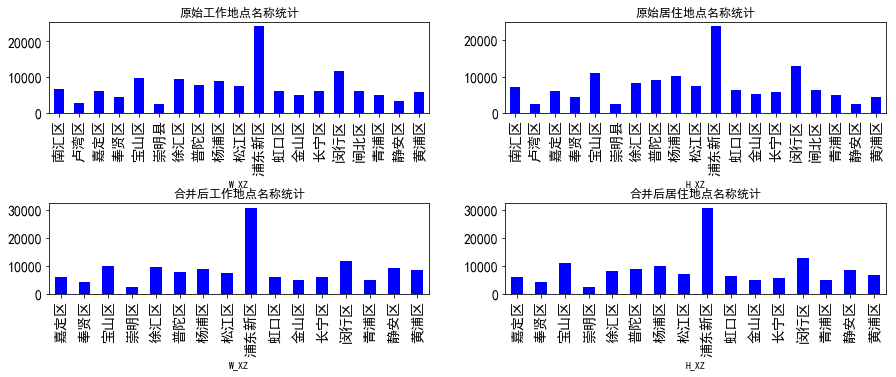

In [14]:
# 统计绘图
fig, ax = plt.subplots(2,2,figsize=(15,10))
plt.subplots_adjust(hspace=1)
plt.subplot(2,2,1)
hwSHOW = hwSHO.groupby('W_XZ').PersonID.count()
hwSHOW[hwSHOW > 20].plot(kind='bar',figsize=(15,5),fontsize=14,color='b',title='原始工作地点名称统计')
plt.subplot(2,2,2)
hwSHO.groupby('H_XZ').PersonID.count().plot(kind='bar',figsize=(15,5),fontsize=14,color='b',title='原始居住地点名称统计')
plt.subplot(2,2,3)
hwSH.groupby('W_XZ').PersonID.count().plot(kind='bar',figsize=(15,5),fontsize=14,color='b',title='合并后工作地点名称统计')
plt.subplot(2,2,4)
hwSH.groupby('H_XZ').PersonID.count().plot(kind='bar',figsize=(15,5),fontsize=14,color='b',title='合并后居住地点名称统计')

In [15]:
# 职住统计
hwSH_cnt = hwSH.groupby(['H_XZ','W_XZ']).PersonID.count().reset_index()
hwSH_cnt.rename(columns={'PersonID':'cnt'},inplace=True)

# 扩样
expandSH = hwSH_cnt.groupby('H_XZ').cnt.sum().reset_index()
expandSH = pd.merge(expandSH, pop_sh, left_on='H_XZ',right_on='County')
expandSH['factor'] = expandSH.population / expandSH.cnt * 10000   # 扩样因子

hwSH_ncnt = pd.merge(hwSH_cnt,expandSH[['H_XZ','factor']], on='H_XZ')
hwSH_ncnt['new_cnt'] = hwSH_ncnt.cnt * hwSH_ncnt.factor

# hwSH_ncnt.to_csv('./shanghai_homework_county_byxz.csv',index=False,encoding='gb2312')

#### 乡镇职住统计

In [16]:
grid = gpd.read_file('E:\\zy城市群数据分析\\0栅格数据\\栅格-乡镇对应\\grid_new.shp')

In [17]:
grid.head()

,id,LONCOL,LATCOL,HBLON,HBLAT,name,County,City,Province,GridRing,TownRing,geometry
0,0,0,281,118.357348,31.931298,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.36 31.92904945779842, 118.354695..."
1,1,0,282,118.357348,31.935794,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.36 31.93354606300484, 118.354695..."
2,2,0,283,118.357348,31.940291,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.36 31.93804266821126, 118.354695..."
3,3,1,281,118.362652,31.931298,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.3653043927706 31.92904945779842,..."
4,4,1,282,118.362652,31.935794,星甸街道,浦口区,南京市,江苏省,0,0,"POLYGON ((118.3653043927706 31.93354606300484,..."


In [20]:
hw_sh = tripSH.loc[tripSH.Tpurpose.isin(['W','H']),['PersonID','HomeID','Tpurpose','TO_X','TO_Y']].dropna()
hw_sh['loncol'] = hw_sh.TO_X.apply(lambda x: int((x-(118.36 - 0.005304 / 2))/0.005304))
hw_sh['latcol'] = hw_sh.TO_Y.apply(lambda y: int((y-(30.67 - 0.0044966 / 2))/ 0.0044966))
# hw_sh['loc'] = hw_sh.loncol.astype(str) + '|' + hw_sh.latcol.astype(str)

In [22]:
home_sh = hw_sh[hw_sh.Tpurpose == 'H']
home_sh = home_sh[['PersonID','loncol','latcol']].groupby('PersonID').agg(lambda x: x.value_counts().index[0])

In [23]:
work_sh = hw_sh[hw_sh.Tpurpose == 'W']
work_sh = work_sh[['PersonID','loncol','latcol']].groupby('PersonID').agg(lambda x: x.value_counts().index[0])

hwsh_grid = pd.merge(home_sh,work_sh,left_index=True,right_index=True,how='inner',suffixes=['_h','_w'])

In [24]:
hwsh_grid.head()

,loncol_h,latcol_h,loncol_w,latcol_w
PersonID,,,,
1,586,126,502,68
2,586,126,502,68
7,521,106,537,107
10,521,106,534,107
13,586,126,508,74


#### 按区县人口扩样

In [25]:
hwsh_temp = pd.merge(hwsh_grid,grid[['LONCOL','LATCOL','County']],\
                     left_on=['loncol_h','latcol_h'],right_on=['LONCOL','LATCOL'],suffixes=['','_h'],how='inner')
hwsh_county = pd.merge(hwsh_temp,grid[['LONCOL','LATCOL','County']],\
                     left_on=['loncol_w','latcol_w'],right_on=['LONCOL','LATCOL'],suffixes=['_h','_w'],how='inner')

hwsh_county_cnt = hwsh_county.groupby(['County_h','County_w']).loncol_h.count().reset_index()
hwsh_county_cnt.rename(columns={'loncol_h':'cnt'},inplace=True)

# 扩样
county_pop = hwsh_county_cnt.groupby('County_h').cnt.sum().reset_index()

county_expand = pd.merge(county_pop,pop_sh,left_on='County_h',right_on='County')
county_expand['factor'] = county_expand.population / county_expand.cnt * 10000

hwsh_county_res = pd.merge(hwsh_county_cnt,county_expand[['County_h','factor']],on='County_h')
hwsh_county_res['expandcnt'] = hwsh_county_res.cnt * hwsh_county_res.factor

In [26]:
hwsh_county_res.head()

,County_h,County_w,cnt,factor,expandcnt
0,嘉定区,嘉定区,1664,631.709265,1.051164e+06
1,嘉定区,奉贤区,23,631.709265,1.452931e+04
2,嘉定区,宝山区,103,631.709265,6.506605e+04
3,嘉定区,崇明区,5,631.709265,3.158546e+03
4,嘉定区,徐汇区,30,631.709265,1.895128e+04


In [ ]:
hwsh_county_res.to_csv('E:\\zhpy\\2travel_survey_2009SH\\shanghai_homework_county_bygrid.csv',index=False)

#### 按乡镇人口扩样

In [27]:
pop_shtown = pd.read_csv('E:\\zy城市群数据分析\\0基础数据\\上海乡镇人口数据.csv',encoding='gbk')  # 上海乡镇人口

In [29]:
hwsh_temp = pd.merge(hwsh_grid,grid[['LONCOL','LATCOL','County','name']],\
                     left_on=['loncol_h','latcol_h'],right_on=['LONCOL','LATCOL'],suffixes=['','_h'],how='inner')
hwsh_town = pd.merge(hwsh_temp,grid[['LONCOL','LATCOL','County','name']],\
                     left_on=['loncol_w','latcol_w'],right_on=['LONCOL','LATCOL'],suffixes=['_h','_w'],how='inner')

In [30]:
hwsh_town_cnt = hwsh_town.groupby(['name_h','County_h','name_w','County_w']).loncol_h.count().reset_index()
hwsh_town_cnt.rename(columns={'loncol_h':'cnt'},inplace=True)

In [31]:
# 扩样
town_pop = hwsh_town_cnt.groupby(['name_h','County_h']).cnt.sum().reset_index()

town_expand = pd.merge(town_pop,pop_shtown,left_on=['name_h','County_h'],right_on=['name','County'])
town_expand['factor'] = town_expand.population / town_expand.cnt

In [32]:
hwsh_town_res = pd.merge(hwsh_town_cnt,town_expand[['name_h','County_h','factor']],on=['name_h','County_h'])
hwsh_town_res['expandcnt'] = hwsh_town_res.cnt * hwsh_town_res.factor

In [33]:
hwsh_town_res.head()

,name_h,County_h,name_w,County_w,cnt,factor,expandcnt
0,七宝镇,闵行区,七宝镇,闵行区,211,371.493508,78385.130236
1,七宝镇,闵行区,三林镇,浦东新区,3,371.493508,1114.480525
2,七宝镇,闵行区,中山街道,松江区,3,371.493508,1114.480525
3,七宝镇,闵行区,临汾路街道,静安区,1,371.493508,371.493508
4,七宝镇,闵行区,九亭镇,松江区,2,371.493508,742.987016


In [ ]:
hwsh_town_res.to_csv('E:\\zhpy\\2travel_survey_2009SH\\shanghai_homework_town_bygrid.csv',index=False)

### (2) 南京

In [34]:
# 南京-----------------------------------------------------------------
familyNJ = pd.read_excel('./2015年南京市居民出行数据.xlsx',sheet_name='家庭',usecols=['家庭编号','行政区','街道名称',\
                         '出行月','出行日','家庭坐标X','家庭坐标Y'], dtype={'出行月':str,'出行日':str})
familyNJ.rename(columns={'家庭编号':'HomeID','行政区':'H_XZ','街道名称':'H_JD','出行月':'month','出行日':'day',\
                       '家庭坐标X':'HomeCoor_X','家庭坐标Y':'HomeCoor_Y'},inplace=True)
familyNJ['date'] = familyNJ[['month','day']].apply(lambda r: '2015' + r.month.zfill(2) + r.day, axis=1)
familyNJ['ifworkday'] = familyNJ.date.apply(lambda x: '工作日' if datetime.datetime.strptime(x,'%Y%m%d').weekday() <= 4 else '双休日') # 4为周五


personNJ = pd.read_excel('./2015年南京市居民出行数据.xlsx',sheet_name='成员',\
                         usecols=['家庭编号','成员编号','行政区','街道名称','性别','年龄','文化程度','职业'])
personNJ.rename(columns={'家庭编号':'HomeID','成员编号':'PersonID','行政区':'H_XZ','街道名称':'H_JD',\
                         '性别':'Gender','年龄':'Age','文化程度':'Education','职业':'Occupant'},inplace=True)


tripNJ = pd.read_excel('./2015年南京市居民出行数据.xlsx',sheet_name='出行',usecols=['家庭编号','成员编号','出行编号','出发时间','到达时间',\
                    '出发地坐标X','出发地坐标Y','到达地坐标X','到达地坐标Y','出行目的','同行人数（本人除外）'],\
                    dtype={'出发时间':str, '到达时间':str})
tripNJ.rename(columns={'家庭编号':'HomeID','成员编号':'PersonID','出行编号':'TripID','出发时间':'Stime','到达时间':'Etime',\
                    '出发地坐标X':'FROM_X','出发地坐标Y':'FROM_Y','到达地坐标X':'TO_X','到达地坐标Y':'TO_Y',\
                     '出行目的':'Tpurpose','同行人数（本人除外）':'accompany'},inplace=True)

def time_string_format(t):
    # 将travel中time转换为时间格式
    hm = t.zfill(5)
    hms = hm[:2] + ':' + hm[2:] + ':00'
    return hms

tripNJ['Stime'] = tripNJ['Stime'].apply(lambda x: time_string_format(x))
tripNJ['Etime'] = tripNJ['Etime'].apply(lambda x: time_string_format(x))
tripNJ.sort_values(['HomeID','PersonID','Stime'],inplace=True)

# modes = {'1':'Work', '2':'School', '3':'Shop', '4':'Entertain', '5':'Business', '6':'Take', '7':'Home', '8':'Other'}
modes = {'上班':'W', '上学':'L', '商场购物':'S', '文娱体育':'E', '商业会务活动':'B', '接送':'T', '回家':'H', \
         '探亲访友':'O','看病探病':'O','日常生活购物':'S','散步':'O','外出餐饮':'O','其他自由目的':'O','贩卖、配送、采购':'O',\
         '其他业务目的':'O','补习、培训班':'O','其他回程':'O','观光旅游':'O','作业、修理':'O','农林渔业作业':'O'}
tripNJ.Tpurpose = tripNJ.Tpurpose.map(modes)

In [35]:
stayNJ = pd.read_csv('./nanjing_stay.csv')

hw_nj = stayNJ[stayNJ.activity == 'W']
hw_nj = hw_nj[['HomeID','PersonID','Slon','Slat','HomeCoor_X','HomeCoor_Y','activity']]
hw_nj.drop_duplicates('PersonID',keep='first',inplace=True)
hw_nj.reset_index(drop=True,inplace=True)

In [36]:
hw_nj = hw_nj[(hw_nj.Slon.str.contains('118')  | hw_nj.Slon.str.contains('119'))]
hw_nj.Slon = hw_nj.Slon.astype(float)

In [37]:
pop_nj = pd.DataFrame(\
[['玄武区',60.02],\
['秦淮区',100.03],\
['建邺区',47.26],\
['鼓楼区',116.84],\
['浦口区',79.88],\
['栖霞区',71.79],\
['雨花台区',45.45],\
['江宁区',124.85],\
['六合区',96.35],\
['溧水区',46.39],\
['高淳区',44.64]],columns=['County','population'])

In [38]:
hw_nj['loncol_h'] = hw_nj.HomeCoor_X.apply(lambda x: int((x-(118.36 - 0.005304 / 2))/0.005304))
hw_nj['latcol_h'] = hw_nj.HomeCoor_Y.apply(lambda y: int((y-(30.67 - 0.0044966 / 2))/ 0.0044966))
hw_nj['loncol_w'] = hw_nj.Slon.apply(lambda x: int((x-(118.36 - 0.005304 / 2))/0.005304))
hw_nj['latcol_w'] = hw_nj.Slat.apply(lambda y: int((y-(30.67 - 0.0044966 / 2))/ 0.0044966))

In [39]:
hwnj_temp = pd.merge(hw_nj,grid[['LONCOL','LATCOL','County']],\
                     left_on=['loncol_h','latcol_h'],right_on=['LONCOL','LATCOL'],suffixes=['','_h'],how='inner')
hwnj_county = pd.merge(hwnj_temp,grid[['LONCOL','LATCOL','County']],\
                     left_on=['loncol_w','latcol_w'],right_on=['LONCOL','LATCOL'],suffixes=['_h','_w'],how='inner')

In [40]:
hwnj_county_cnt = hwnj_county.groupby(['County_h','County_w']).loncol_h.count().reset_index()
hwnj_county_cnt.rename(columns={'loncol_h':'cnt'},inplace=True)

In [41]:
# 扩样
county_pop_nj = hwnj_county_cnt.groupby('County_h').cnt.sum().reset_index()

county_expand_nj = pd.merge(county_pop_nj,pop_nj,left_on='County_h',right_on='County')
county_expand_nj['factor'] = county_expand_nj.population / county_expand_nj.cnt * 10000

In [42]:
hwnj_county_res = pd.merge(hwnj_county_cnt,county_expand_nj[['County_h','factor']],on='County_h')
hwnj_county_res['expandcnt'] = hwnj_county_res.cnt * hwnj_county_res.factor

In [43]:
hwnj_county_res.head()

,County_h,County_w,cnt,factor,expandcnt
0,六合区,六合区,2192,396.992171,870206.839720
1,六合区,建邺区,13,396.992171,5160.898228
2,六合区,栖霞区,26,396.992171,10321.796457
3,六合区,江宁区,9,396.992171,3572.929543
4,六合区,浦口区,105,396.992171,41684.177998


In [ ]:
hwnj_county_res.to_csv('E:\\zhpy\\2travel_survey_2009SH\\nanjing_homework_county_bygrid.csv',index=False)

#### by xingzhen

In [45]:
# 搜索居住工作所对应的的栅格
town = gpd.read_file('E:\\zy城市群数据分析\\0栅格数据\\9市街道区划\\9市街道区划-合并.shp')   # 乡镇数据
townNJ = town[town.City=='南京市']
townNJ.reset_index(drop=True,inplace=True)

workNJ = hw_nj.copy()
survey_town = list()
for pers in workNJ.PersonID.unique():
    workplace = shapely.geometry.Point(workNJ.loc[workNJ.PersonID==pers,['Slon','Slat']].values[0])
    wname, wcounty = '', ''
    for j in range(len(townNJ)):
        town_polygon = townNJ.loc[j,'geometry']
        if town_polygon.contains(workplace):
            wname, wcounty = townNJ.loc[j,['name','County']].values.tolist()
    survey_town.append([pers, wname, wcounty])

In [46]:
surveyBase = pd.DataFrame(survey_town,columns=['PersonID','name_w','County_w'])
surveyBase.dropna(inplace=True)
surveyBase = surveyBase[surveyBase.County_w != '']

survey_county = pd.merge(personNJ,surveyBase,on='PersonID',how='right')

hwNJ_cnt = survey_county.groupby(['H_XZ','County_w']).PersonID.count().reset_index()
hwNJ_cnt.rename(columns={'PersonID':'cnt','County_w':'W_XZ'},inplace=True)   

In [47]:
hwNJ_cnt.head()

,H_XZ,W_XZ,cnt
0,六合区,六合区,2209
1,六合区,建邺区,13
2,六合区,栖霞区,26
3,六合区,江宁区,9
4,六合区,浦口区,94


In [48]:
# 扩样
expandNJ = hwNJ_cnt.groupby('H_XZ').cnt.sum().reset_index()
expandNJ = pd.merge(expandNJ, pop_nj, left_on='H_XZ',right_on='County')
expandNJ['factor'] = expandNJ.population / expandNJ.cnt * 10000   # 扩样因子

hwNJ_ncnt = pd.merge(hwNJ_cnt,expandNJ[['H_XZ','factor']], on='H_XZ')
hwNJ_ncnt['new_cnt'] = hwNJ_ncnt.cnt * hwNJ_ncnt.factor

In [ ]:
hwNJ_ncnt.to_csv('./nanjing_homework_county_byxz.csv.csv',index=False,encoding='gb2312')